Tips data analysis by Classification tools

In [1]:
%matplotlib inline
tips=sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [2]:
tips['sex'] = tips['sex'].apply(lambda x: 1 if x == 'Male' else 0).astype('int64')
tips['smoker'] = tips['smoker'].apply(lambda x: 1 if x == 'Yes' else 0).astype('int64')
tips['time'] = tips['time'].apply(lambda x: 1 if x == 'Dinner' else 0).astype('int64')
tips['day'] = tips['day'].apply(lambda x: 0 if x == 'Thur' else 1 if x =='Fri' else 2 if x=='Sat' else 3).astype('int64')

In [3]:
tips.describe()

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,0.643443,0.381148,1.725410,0.721311,2.569672
std,8.902412,1.383638,0.479967,0.486667,1.155774,0.449276,0.951100
min,3.070000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.347500,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,17.795000,2.900000,1.000000,0.000000,2.000000,1.000000,2.000000
75%,24.127500,3.562500,1.000000,1.000000,3.000000,1.000000,3.000000
max,50.810000,10.000000,1.000000,1.000000,3.000000,1.000000,6.000000


In [4]:
tips['upper3'] = tips['tip'].apply(lambda x: 1 if x >=3 else 0)
tips['upper5'] = tips['tip'].apply(lambda x: 1 if x >5 else 0)
tips['target'] = tips['tip'].apply(lambda x: 'upper5' if x>5 else 'upper3' if x>3 else 'others')

# logistic

In [5]:
model3 = sm.Logit.from_formula("upper3 ~ total_bill + sex + smoker + day + time + size", tips)
result3 = model3.fit(disp=0)
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 upper3   No. Observations:                  244
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Mar 2018   Pseudo R-squ.:                  0.2610
Time:                        13:26:59   Log-Likelihood:                -124.98
converged:                       True   LL-Null:                       -169.12
                                        LLR p-value:                 6.910e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1327      0.653     -6.334      0.000      -5.412      -2.854
total_bill     0.1745      0.032      5.493      0.000       0.112       0.237
sex           -0.1579      0.332     -0.475      0.635      -0.809       0.494
smoker         0.1951      0.330      0.591      0.554      -0.452       0.842
day            0.0670      0.280      0.239      0.811      -0.483       0.616
time           0.4271      0.713      0.599      0.549      -0.971       1.825
size           0.1686      0.226      0.748      0.455      -0.273       0.611
==============================================================================
"""

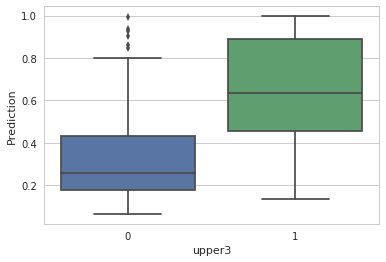

In [6]:
tips["Prediction"] = result3.predict(tips)
sns.boxplot(x="upper3", y="Prediction", data=tips)
plt.show()

In [7]:
model5 = sm.Logit.from_formula("upper5 ~ total_bill + sex + smoker + day + time + size", tips)
result5 = model5.fit(disp=0)
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 upper5   No. Observations:                  244
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Mar 2018   Pseudo R-squ.:                  0.2643
Time:                        13:27:00   Log-Likelihood:                -47.260
converged:                       True   LL-Null:                       -64.241
                                        LLR p-value:                 6.841e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.0832      1.324     -5.348      0.000      -9.679      -4.487
total_bill     0.1076      0.032      3.356      0.001       0.045       0.170
sex            0.3393      0.655      0.518      0.605      -0.945       1.624
smoker        -0.3067      0.638     -0.481      0.631      -1.556       0.943
day            0.3579      0.549      0.652      0.514      -0.717       1.433
time          -0.4596      1.593     -0.288      0.773      -3.582       2.663
size           0.4669      0.291      1.606      0.108      -0.103       1.037
==============================================================================
"""

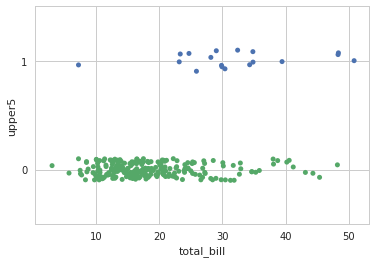

In [8]:
sns.stripplot(x="total_bill", y="upper5", data=tips, jitter=True, orient='h', order=[1, 0])
plt.grid(True)
plt.show()

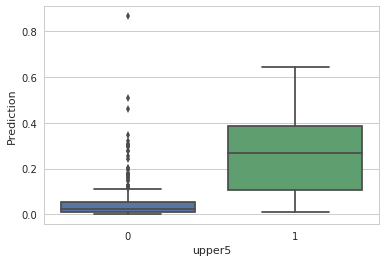

In [9]:
tips["Prediction"] = result5.predict(tips)
sns.boxplot(x="upper5", y="Prediction", data=tips)
plt.show()

In [10]:
from sklearn.metrics import *
X =tips[['total_bill', 'sex', 'smoker', 'day', 'time', 'size']]
y3 = tips['upper3']
y_pred = result3.predict(X).apply(lambda x: 1 if x >=0.5 else 0)
print("Confusion Matrix:\n\n",confusion_matrix(y3, y_pred), "\n")
target_names = ['others', 'upper3']
print("Classification report:\n\n",classification_report(y3, y_pred, target_names=target_names))

Confusion Matrix:

 [[99 24]
 [39 82]] 

Classification report:

              precision    recall  f1-score   support

     others       0.72      0.80      0.76       123
     upper3       0.77      0.68      0.72       121

avg / total       0.75      0.74      0.74       244



AUC : 0.7412819995968555


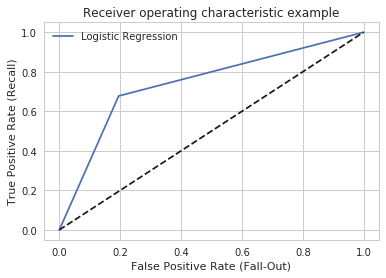

In [11]:
fpr3, tpr3, thresholds3 = roc_curve(y3, y_pred)
plt.plot(fpr3, tpr3, label="Logistic Regression")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
print ("AUC :",auc(fpr3, tpr3))
plt.show()

In [12]:
y5 = tips['upper5']
y_pred = result5.predict(X).apply(lambda x: 1 if x >=0.5 else 0)
print("Confusion Matrix:\n\n",confusion_matrix(y5, y_pred), "\n")
target_names = ['others', 'upper5']
print("Classification report:\n\n",classification_report(y5, y_pred, target_names=target_names))

Confusion Matrix:

 [[224   2]
 [ 15   3]] 

Classification report:

              precision    recall  f1-score   support

     others       0.94      0.99      0.96       226
     upper5       0.60      0.17      0.26        18

avg / total       0.91      0.93      0.91       244



AUC : 0.5789085545722714


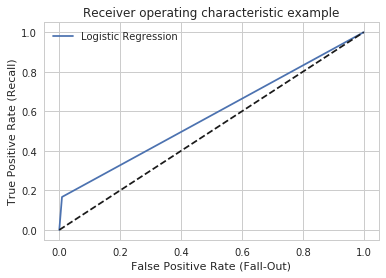

In [13]:
fpr5, tpr5, thresholds5 = roc_curve(y5, y_pred)

plt.plot(fpr5, tpr5, label="Logistic Regression")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
print ("AUC :",auc(fpr5, tpr5))
plt.show()

## 10% 확률만 있어도 부자로 체크!

In [14]:
y5 = tips['upper5']
y_pred = result5.predict(X).apply(lambda x: 1 if x >=0.1 else 0) 
print("Confusion Matrix:\n\n",confusion_matrix(y5, y_pred), "\n")
target_names = ['others', 'upper5']
print("Classification report:\n\n",classification_report(y5, y_pred, target_names=target_names))

Confusion Matrix:

 [[190  36]
 [  4  14]] 

Classification report:

              precision    recall  f1-score   support

     others       0.98      0.84      0.90       226
     upper5       0.28      0.78      0.41        18

avg / total       0.93      0.84      0.87       244



부자를 찾아낼 확률이 올라간다! 물론 False Positive도 오른다.

AUC : 0.8092428711897738


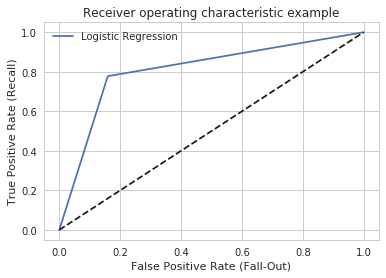

In [15]:
fpr5, tpr5, thresholds5 = roc_curve(y5, y_pred)

plt.plot(fpr5, tpr5, label="Logistic Regression")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
print ("AUC :",auc(fpr5, tpr5))
plt.show()

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

y = tips['upper5']

model1 = LogisticRegression().fit(X, y)
y_hat1 = model1.predict(X)

model2 = SVC(gamma=0.0026, C=10).fit(X, y)
y_hat2 = model2.predict(X)

print(confusion_matrix(y, y_hat1), "\n")
print(confusion_matrix(y, y_hat2))

print(classification_report(y, model1.predict(X)))
print(classification_report(y, model2.predict(X)))

[[226   0]
 [ 18   0]] 

[[226   0]
 [ 17   1]]
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       226
          1       0.00      0.00      0.00        18

avg / total       0.86      0.93      0.89       244

             precision    recall  f1-score   support

          0       0.93      1.00      0.96       226
          1       1.00      0.06      0.11        18

avg / total       0.94      0.93      0.90       244



/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


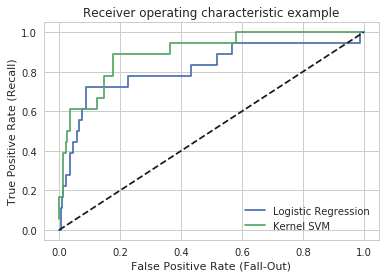

In [17]:
fpr1, tpr1, thresholds1 = roc_curve(y, model1.decision_function(X))
fpr2, tpr2, thresholds1 = roc_curve(y, model2.decision_function(X))

plt.plot(fpr1, tpr1, label="Logistic Regression")
plt.plot(fpr2, tpr2, label="Kernel SVM")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver operating characteristic example')
plt.show()

---

### QDA LDA

In [19]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() # 객체 생성
y = tips['target']
y1 = lb.fit_transform(tips['target'])

In [20]:
from sklearn.discriminant_analysis import *
qda = QuadraticDiscriminantAnalysis().fit(X, y)
lda = LinearDiscriminantAnalysis(n_components=3, solver="svd").fit(X, y)

y_pred = qda.predict(X)
y_pred2 = lda.predict(X)

print("QDA confusion_matrix \n\n",confusion_matrix(y, y_pred),"\n\n")
print("LDA confusion_matrix \n\n",confusion_matrix(y, y_pred2),"\n\n")

target_names = ['others', 'upper3','upper5']
print("QDA",classification_report(y, y_pred, target_names=target_names))
print("LDA",classification_report(y, y_pred2, target_names=target_names))


QDA confusion_matrix 

 [[126  19   1]
 [ 44  33   3]
 [  3   9   6]] 


LDA confusion_matrix 

 [[132  13   1]
 [ 47  26   7]
 [  2  11   5]] 


QDA              precision    recall  f1-score   support

     others       0.73      0.86      0.79       146
     upper3       0.54      0.41      0.47        80
     upper5       0.60      0.33      0.43        18

avg / total       0.66      0.68      0.66       244

LDA              precision    recall  f1-score   support

     others       0.73      0.90      0.81       146
     upper3       0.52      0.33      0.40        80
     upper5       0.38      0.28      0.32        18

avg / total       0.64      0.67      0.64       244



In [21]:
from sklearn.multiclass import OneVsRestClassifier
model1 = OneVsRestClassifier(QuadraticDiscriminantAnalysis()).fit(X, y)
model2 = OneVsRestClassifier(LinearDiscriminantAnalysis(n_components=3, 
                                 solver="svd", store_covariance=True)).fit(X, y)

auc: 0.8066116857701984
auc: 0.7458079268292683
auc: 0.9164208456243854


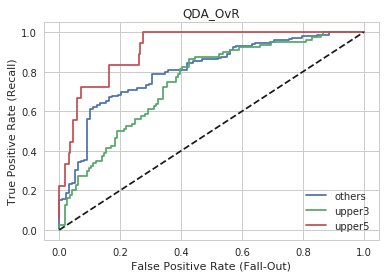

In [22]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model1.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model1.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model1.decision_function(X)[:,2])

plt.plot(fpr1, tpr1, label="others")
plt.plot(fpr2, tpr2, label="upper3")
plt.plot(fpr3, tpr3, label="upper5")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('QDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()

auc: 0.8171652222532848
auc: 0.7314024390243903
auc: 0.8581612586037364


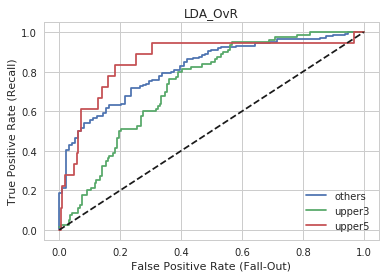

In [23]:
fpr1, tpr1, thresholds1 =roc_curve(y1[:,0], model2.decision_function(X)[:,0])
fpr2, tpr2, thresholds2 =roc_curve(y1[:,1], model2.decision_function(X)[:,1])
fpr3, tpr3, thresholds3 =roc_curve(y1[:,2], model2.decision_function(X)[:,2])

plt.plot(fpr1, tpr1, label="others")
plt.plot(fpr2, tpr2, label="upper3")
plt.plot(fpr3, tpr3, label="upper5")

plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('LDA_OvR')
print ("auc:",auc(fpr1, tpr1))
print ("auc:",auc(fpr2, tpr2))
print ("auc:",auc(fpr3, tpr3))

plt.show()